# Running trVAE on Haber et. al dataset for batch-removal and style transfer

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import trvae

Using TensorFlow backend.


In [3]:
sc.set_figure_params(dpi=100)

## Loading & preparing data

`condition_key` is the key for your batch or conditions labels in your `adata.obs`

In [27]:
condition_key = "condition"

In [5]:
adata = sc.read("data/haber_count.h5ad")
adata

AnnData object with n_obs × n_vars = 9842 × 15215
    obs: 'batch', 'barcode', 'condition', 'cell_label'

## Normalizing & Extracting Top 2000 Highly Variable Genes 
One  can use more genes but in order to train the network quickly, we will extract top 2000 genes. This can be done with `normalize_hvg` function in the `tl` module of trVAE package. The function accepts the following arguments:

* __adata__: adata containing raw counts in its `.X` attribute.
* __target_sum__: total counts per cell after normalization
* __size_factors__: whether to normalize the `adata` and put total counts per cell in "size_factors" column of `adata.obs` (`True` is recommended).
* __scale_input__: whether to scale the dataset after normalization (`False` is recommended).
* __logtrans_input__: whether to log-transform the `adata` after normalization (`True` is recommended).
* __n_top_genes__: number of highly variable genes to be selected after `adata` normalization.

In [6]:
adata = trvae.tl.normalize_hvg(adata, 
                               target_sum=1e4,
                               size_factors=True, 
                               scale_input=False, 
                               logtrans_input=True, 
                               n_top_genes=2000)
adata

AnnData object with n_obs × n_vars = 9842 × 2000
    obs: 'batch', 'barcode', 'condition', 'cell_label', 'size_factors'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'

## Original Data UMAP Visualization

In [7]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


just for visualization, no cell type label is required for the model

In [30]:
cell_type_key = "cell_label"

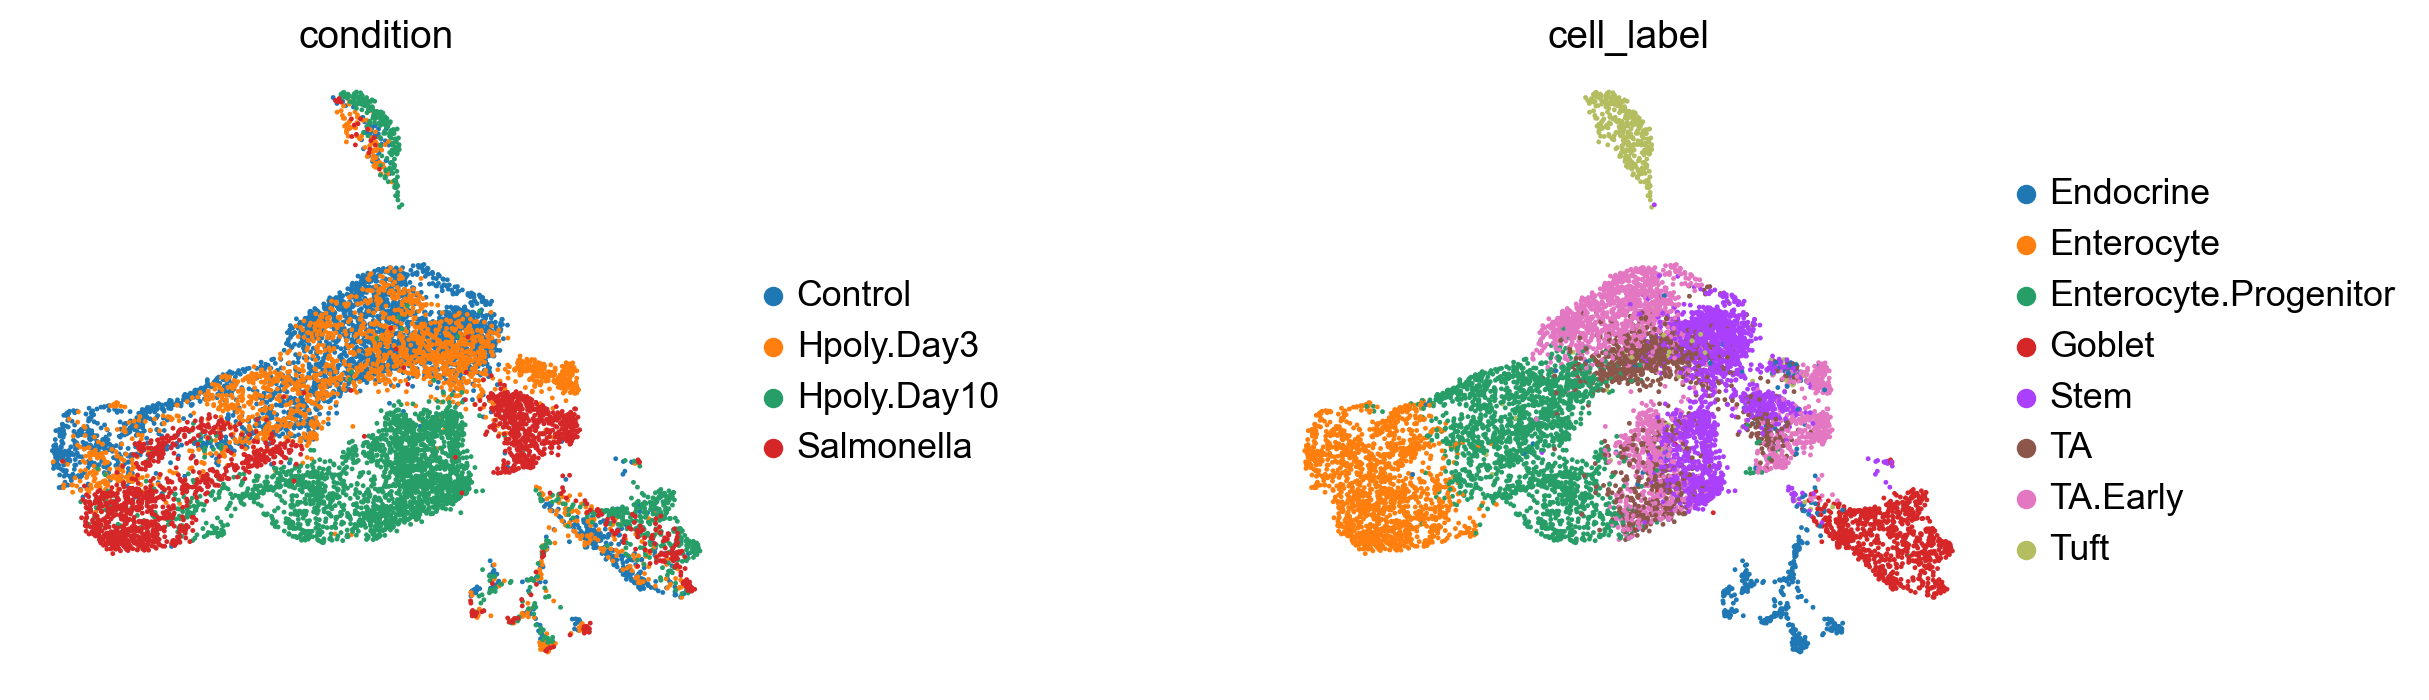

In [8]:
sc.pl.umap(adata, color=[condition_key, cell_type_key], 
           wspace=0.6, 
           frameon=False)

## Calculate number of batches

In [7]:
conditions = adata.obs[condition_key].unique().tolist()

## Create the network
Some of network parameters:
 - __x_dimension__: size input features (necessary)
 - __conditons__: list of unique batches(studies) names
 - __architecture__: architecture of the network (optional)
 - __output_activation__: activation function of trVAE's last layer 
 - __alpha__: coefficient of KL Divergence loss (optional)
 - __beta__: coefficient of MMD loss (optional)
 - __eta__: coefficient of reconstruction (MSE or SSE) loss (optional)
     can be one of the `relu`, `leaky_relu`, `linear`, ... 
 - __gene_names__: list of gene names (`adata.var_names.tolist()`)
 - __loss_fn__: trVAE's loss function (Has to be one of `mse` or `sse`)

In [10]:
network = trvae.models.trVAE(x_dimension=adata.shape[1],
                             architecture=[256,64],
                             z_dimension=10,
                             gene_names=adata.var_names.tolist(),
                             conditions=conditions,
                             model_path='./models/trVAE/haber/',
                             alpha=0.0001,
                             beta=50,
                             eta=100,
                             loss_fn='sse',
                             output_activation='linear')

trVAE' network has been successfully constructed!
trVAE'snetwork has been successfully compiled!


## Training trVAE
You can train scArches with train function with the following parameters:

* __adata__: Annotated dataset used for training and evaluating scArches.
* __condition_key__: name of the column in obs matrix in adata which contains the batch_id for each sample.
* __n_epochs__: number of epochs used to train scArches.
* __batch_size__: number of sample used to sample as mini-batches in order to optimize scArches. Please NOTE that for MSE loss with MMD regularization batch sizes upper that 512 is highly recommended
* __save__: whether to save scArches' model and configs after training phase or not.
* __retrain__: if False and scArches' pretrained model exists in model_path, will restore scArches' weights. Otherwise will train and validate scArches on adata.

In [11]:
network.train(adata,
              condition_key,
              train_size=0.8,
              n_epochs=50,
              batch_size=512,
              early_stop_limit=10,
              lr_reducer=20,
              verbose=5,
              save=True,
              )

 |████████████████████| 100.0%  - loss: 251.2036 - mmd_loss: 0.4532 - recon_loss: 250.7504 - val_loss: 8249.9760 - val_mmd_loss: 70.4720 - val_recon_loss: 8179.50403

trVAE has been successfully saved in ./models/trVAE/haber/.


## Getting corrected latent adata

if you use trVAE for batch-removal we recommend to use z Latent space computed using `get_latent` function This function has the following parameters:

* __adata__: Annotated dataset to be transformed to latent space
* __batch_key__: Name of the column in obs matrix in adata which contains the study for each sample.

In [12]:
latent_adata = network.get_latent(adata, condition_key)
latent_adata

AnnData object with n_obs × n_vars = 9842 × 10
    obs: 'batch', 'barcode', 'condition', 'cell_label', 'size_factors'

## UMAP visualization of latent space

In [13]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

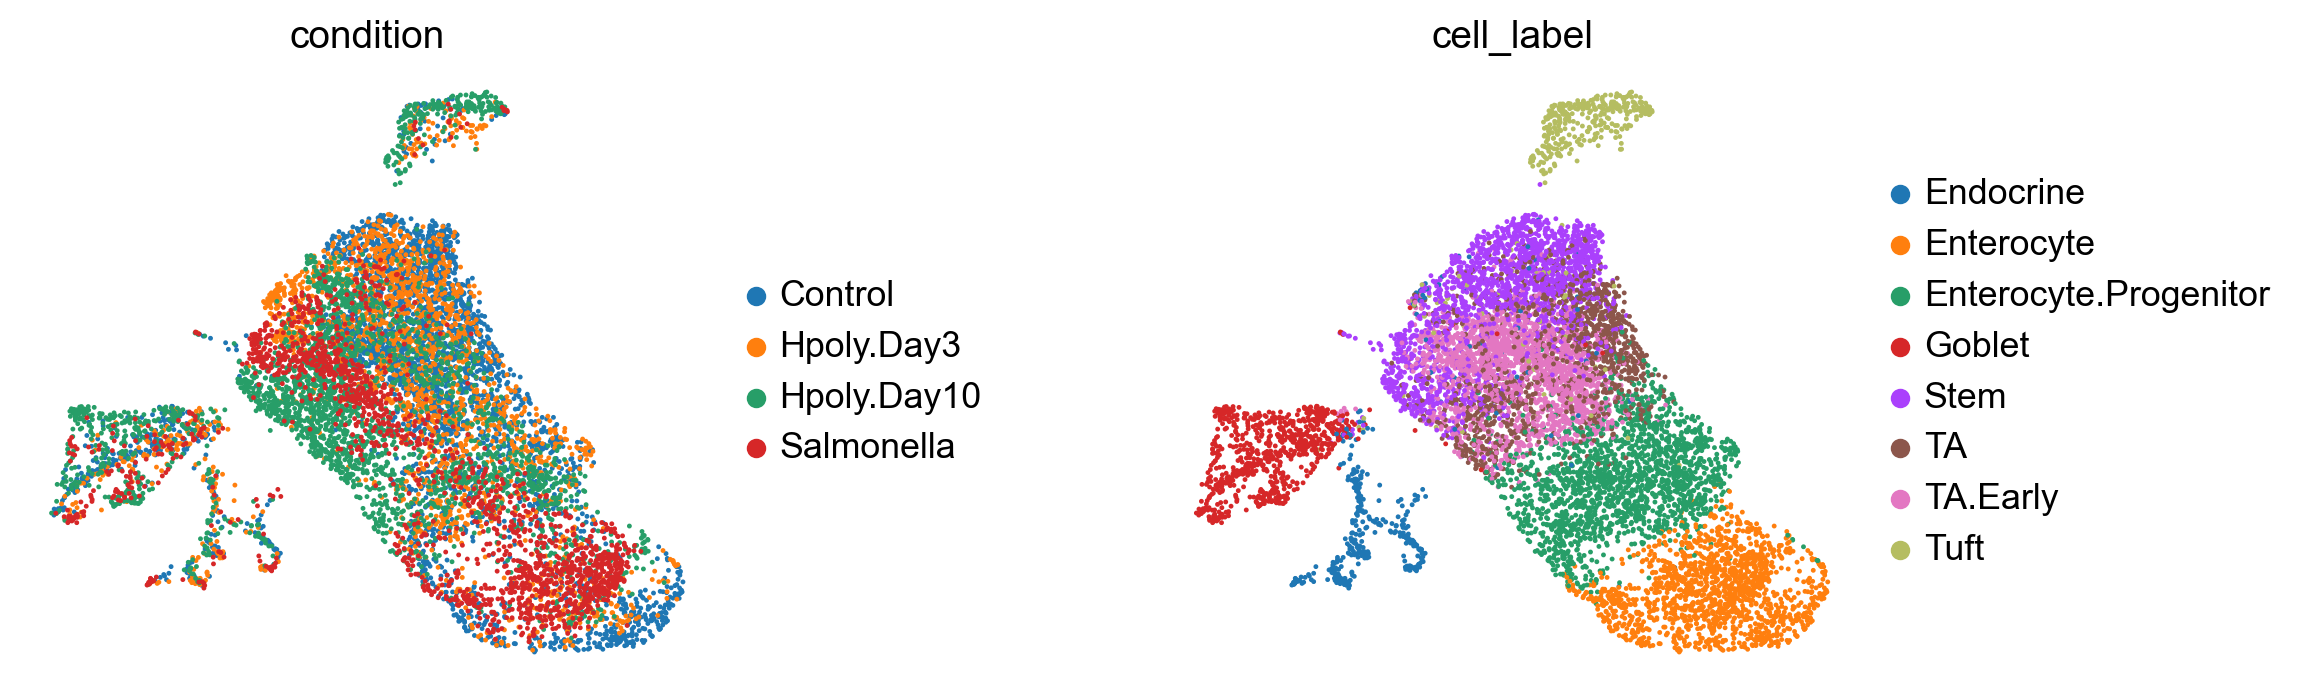

In [14]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5, frameon=False)

### Get corrected gene expression data

we transfer all conditions to the batch labels with maximum number of samples. 
`target_condition` is the the condtion that you want your  source `adata` be transformed to.

In [24]:
 adata.obs[condition_key].value_counts()

Control        3240
Hpoly.Day10    2711
Hpoly.Day3     2121
Salmonella     1770
Name: condition, dtype: int64

In [18]:
target_condition = adata.obs[condition_key].value_counts().index[0]

In [19]:
corrected_data = network.predict(adata,condition_key,target_condition=target_condition)

#### UMAP visualization of corrected gene expression 

In [22]:
sc.pp.neighbors(corrected_data)
sc.tl.umap(corrected_data)

         Falling back to preprocessing with `sc.pp.pca` and default params.


As observed  in the corrected gene expression data all samples were mapped to control cells and are mixd now

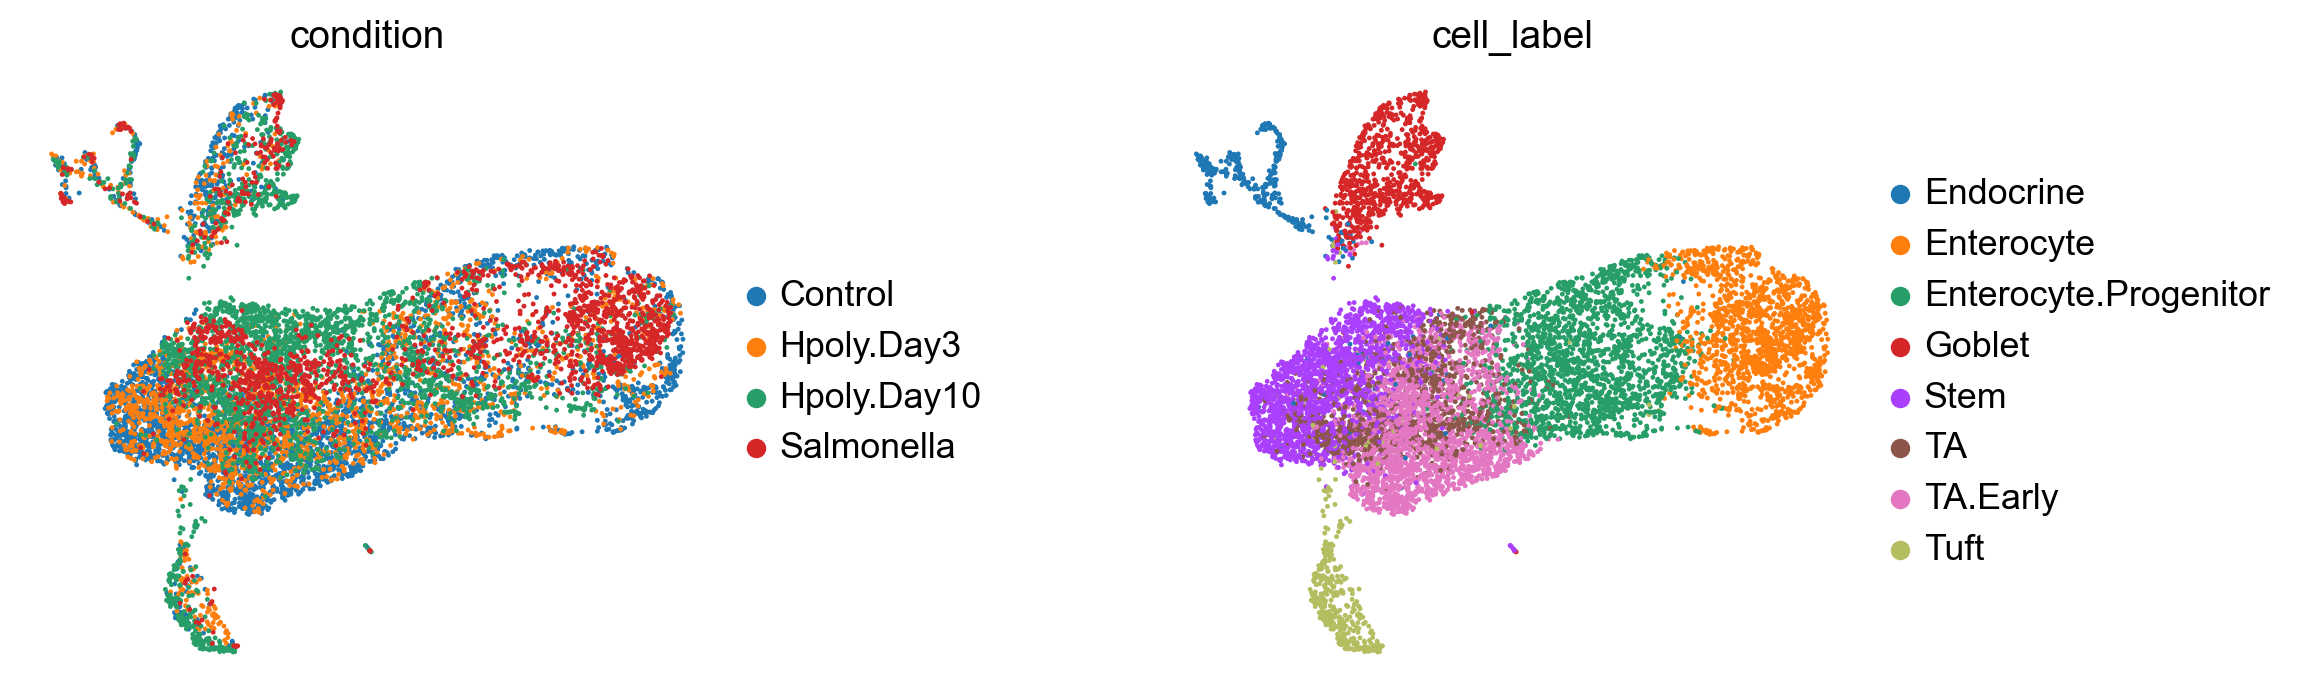

In [23]:
sc.pl.umap(corrected_data, color=[condition_key, cell_type_key], wspace=0.5, frameon=False)